## Это пятая лаба по питону.


In [13]:
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import glob

learning_rate = 0.001
batch_size = 100
epochs = 10

#устанавливаем зерно и случайное значение
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)

1-2. Загрузка и разделение набора данных на выборки.

In [24]:
train_path = 'E:\dataset\\train'
test_path = 'E:\dataset\\test'
val_path = 'E:\dataset\\val'

df = pd.read_csv('dataset.csv', sep = ' ')
df = df.rename(columns={'Absolute_way': 'absolute_way'})
df = df.rename(columns={'Class': 'class_img'})

if not os.path.isdir(train_path):
    os.mkdir(train_path)

if not os.path.isdir(test_path):
    os.mkdir(test_path)

if not os.path.isdir(val_path):
    os.mkdir(val_path)

def load_train(df: pd.core.frame.DataFrame, path: str, i: int) -> None:
    '''
    Загружает i-ую картинку из датафрейма по заданному пути path
    Ключевые аргументы:
        df(pd.core.frame.DataFrame): датафрейм с картинками 
        path(str): путь загрузки картинок
        i(int): номер картинки
    '''
    image_path = df.absolute_way[i]
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(path, f'{df.class_img[i]}.{i}.jpg'), image)
'''
for i in range(840):
    load_train(df, train_path, i)

for i in range(840, 945):
    load_train(df, test_path, i)

for i in range(945, 1050):
    load_train(df, val_path, i)

for i in range(1050, 1890):
    load_train(df, train_path, i)

for i in range(1890, 1995):
    load_train(df, test_path, i)

for i in range(1995, 2100):
    load_train(df, val_path, i)
'''
train_list = glob.glob(os.path.join(train_path,'*.jpg'))
test_list = glob.glob(os.path.join(test_path, '*.jpg'))

train_list, val_list = train_test_split(train_list, test_size=0.1)



'E:\\dataset\\train\\polarbears.131.jpg'

Проверка набора данных.

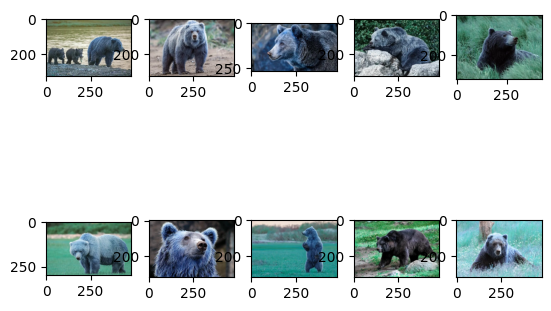

In [8]:
random_idx = np.random.randint(1,200,size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = cv2.imread(train_list[idx])
    plt.imshow(img)
    i+=1

plt.show()

3. Модель свёрточной нейронной сети.

In [11]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        
        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

model = ConvNet().to(device)
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

1680

4. Пайплайн предобработки данных.

In [ ]:
train_transforms =  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

test_transforms = transforms.Compose([   
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])

Предобработка данных.

In [ ]:
class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = cv2.imread(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('\\')[-1].split('.')[0]
        if label == 'polarbears':
            label = 1
        elif label == 'brownbears':
            label = 0
            
        return img_transformed,label


train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform=test_transforms)